In [1]:
# imports
import pandas as pd
import numpy as np
import pickle

from impute_transform import ImputeTransform
#import model_metrics

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from fancyimpute import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [6]:
train_data = pd.read_csv('data/train_data.csv')

In [7]:
X = train_data.drop(columns=['DX','DXSUB'])
y = train_data['DX'].map({3:1, 1:0})
#X = train_data.drop(columns=['DX','DXSUB'])
#y = train_data['DX'].map({3:1, 1:0})

## Metrics
The metrics for a default, cross validated XGBoost model are as follows:

Test Accuracy: 0.932  
Test Log Loss: -0.204  
Test ROC AUC: 0.971  

The code for such classifier is here:  
```xgb_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                           XGBClassifier(max_depth=3, learning_rate=0.1,
                           n_estimators=100,
                           random_state=56, n_jobs=-1))```

# Parameter Tuning for XGBoost

Following the guidelines set out here: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [4]:
impute = ImputeTransform(strategy=MatrixFactorization())
clf = XGBClassifier(
                  learning_rate = 0.1,
                  n_estimators = 1000,
                  max_depth = 3,
                  objective = 'binary:logistic',
                  n_jobs = 6,
                  random_state=56)
#clf = XGBClassifier(
#                  learning_rate = 0.1,
#                  n_estimators = 1000,
#                  max_depth = 5,
#                  min_child_weight = 1,
#                  gamma = 0,
#                  subsample = 0.8,
#                  colsample_bytree = 0.8,
#                  scale_pos_weight=1,
#                  objective = 'binary:logistic',
#                  n_jobs = -1,
#                  random_state=56)

In [5]:
steps = [('impute_transform', impute),
         ('xgboost', clf)]

pipeline = Pipeline(steps)

## Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [6]:
param_test1 = {'xgboost__n_estimators': range(20,301,10)}

gsearch1 = GridSearchCV(pipeline,
                        param_grid=param_test1,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [7]:
%%capture
gsearch1.fit(X, y)

In [8]:
print(gsearch1.best_params_, gsearch1.best_score_)
best_n_estimators = gsearch1.best_params_['xgboost__n_estimators']
_ = pipeline.set_params(xgboost__n_estimators=best_n_estimators)

{'xgboost__n_estimators': 90} 0.978607842939


## Step 2: Tune max_depth and min_child_weight

In [9]:
param_test2 = {'xgboost__max_depth': range(1,10,2),
               'xgboost__min_child_weight': range(1,6,2)}

gsearch2 = GridSearchCV(pipeline,
                        param_grid=param_test2,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [10]:
%%capture
gsearch2.fit(X, y)

In [11]:
print(gsearch2.best_params_, gsearch2.best_score_)

{'xgboost__max_depth': 5, 'xgboost__min_child_weight': 5} 0.977429623099


In [4]:
impute = ImputeTransform(strategy=MatrixFactorization())
clf = XGBClassifier(
                  learning_rate = 0.1,
                  n_estimators = 90,
                  max_depth = 5,
                  min_child_weight = 5,
                  objective = 'binary:logistic',
                  n_jobs = -1,
                  random_state=56)

In [5]:
steps = [('impute_transform', impute),
         ('xgboost', clf)]

pipeline = Pipeline(steps)

### Step 2b: Find optimum values

In [6]:
param_test2a = {'xgboost__max_depth': [4,5,6,7],
                'xgboost__min_child_weight': [4,5,6]}
gsearch2a = GridSearchCV(pipeline,
                         param_grid=param_test2a,
                         scoring='roc_auc',
                         iid=False, cv=3)

In [9]:
%%capture
gsearch2a.fit(X, y)

In [10]:
print(gsearch2a.best_params_, gsearch2a.best_score_)

{'xgboost__max_depth': 4, 'xgboost__min_child_weight': 4} 0.9760565627494762


In [11]:
# Set the new parameters
best_max_depth = gsearch2a.best_params_['xgboost__max_depth']
best_child_weight = gsearch2a.best_params_['xgboost__min_child_weight']
_ = pipeline.set_params(xgboost__max_depth=best_max_depth,
                        xgboost__min_child_weight=best_child_weight)

### Step 2c: Find optimum values

In [12]:
param_test2b = {'xgboost__max_depth': [3,4,5],
                'xgboost__min_child_weight': [3,4,5]}
gsearch2b = GridSearchCV(pipeline,
                         param_grid=param_test2b,
                         scoring='roc_auc',
                         iid=False, cv=3)

In [13]:
%%capture
gsearch2b.fit(X, y)

In [14]:
print(gsearch2b.best_params_, gsearch2a.best_score_)

{'xgboost__max_depth': 5, 'xgboost__min_child_weight': 5} 0.9760565627494762


In [15]:
# Set the new parameters
best_max_depth = gsearch2b.best_params_['xgboost__max_depth']
best_child_weight = gsearch2b.best_params_['xgboost__min_child_weight']
_ = pipeline.set_params(xgboost__max_depth=best_max_depth,
                        xgboost__min_child_weight=best_child_weight)

## Step 3: Tune gamma

In [16]:
param_test3 = {'xgboost__gamma': [i/10.0 for i in range(0,5)]}
gsearch3 = GridSearchCV(pipeline,
                        param_grid=param_test3,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [17]:
%%capture
gsearch3.fit(X, y)

In [18]:
print(gsearch3.best_params_, gsearch3.best_score_)

{'xgboost__gamma': 0.2} 0.9765669606614488


In [19]:
# Set the new parameters
best_gamma = gsearch3.best_params_['xgboost__gamma']
_ = pipeline.set_params(xgboost__gamma=best_max_depth)

### Step 3b: Re-calibrate n_estimators for updated parameters

In [21]:
param_test3b = {'xgboost__n_estimators': range(40,121,10)}

gsearch3b = GridSearchCV(pipeline,
                         param_grid=param_test3b,
                         scoring='roc_auc',
                         iid=False, cv=3)

In [22]:
%%capture
gsearch3b.fit(X, y)

In [23]:
print(gsearch3b.best_params_, gsearch3b.best_score_)

{'xgboost__n_estimators': 40} 0.9791244281401762


In [24]:
best_n_estimators = gsearch3b.best_params_['xgboost__n_estimators']
_ = pipeline.set_params(xgboost__n_estimators=best_n_estimators)

### Step 3c: Re-calibrate n_estimators for updated parameters

In [25]:
param_test3c = {'xgboost__n_estimators': [30, 35, 40, 45, 50, 90]}

gsearch3c = GridSearchCV(pipeline,
                         param_grid=param_test3c,
                         scoring='roc_auc',
                         iid=False, cv=3)

In [26]:
%%capture
gsearch3c.fit(X, y)

In [27]:
print(gsearch3c.best_params_, gsearch3c.best_score_)

{'xgboost__n_estimators': 45} 0.9823776419839412


In [28]:
best_n_estimators = gsearch3c.best_params_['xgboost__n_estimators']
_ = pipeline.set_params(xgboost__n_estimators=best_n_estimators)

## Step 4: Tune subsample and colsample_bytree

In [ ]:
# skippable

## Step 5: Tuning Regularization Parameters

In [ ]:
# skippable

## Step 6: Reducing Learning Rate, Add Trees

In [7]:
impute = ImputeTransform(strategy=MatrixFactorization())
clf = XGBClassifier(
                  learning_rate = 0.01,
                  n_estimators = 45,
                  max_depth = 5,
                  min_child_weight = 5,
                  gamma = 0.2,
                  objective = 'binary:logistic',
                  n_jobs = -1,
                  random_state=56)

steps = [('impute_transform', impute),
         ('xgboost', clf)]

pipeline = Pipeline(steps)

In [8]:
_ = pipeline.set_params(xgboost__learning_rate=0.01)

In [9]:
param_test6 = {'xgboost__n_estimators': range(30,190,10)}

gsearch6 = GridSearchCV(pipeline,
                        param_grid=param_test6,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [10]:
%%capture
gsearch6.fit(X, y)

In [11]:
print(gsearch6.best_params_, gsearch6.best_score_)

{'xgboost__n_estimators': 180} 0.9781366293177317


In [12]:
best_n_estimators = gsearch6.best_params_['xgboost__n_estimators']
_ = pipeline.set_params(xgboost__n_estimators=best_n_estimators)

## Step 6b: Optimize n_estimators (again)

In [13]:
param_test6b = {'xgboost__n_estimators': range(160,210,5)}

gsearch6b = GridSearchCV(pipeline,
                        param_grid=param_test6b,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [14]:
%%capture
gsearch6b.fit(X, y)

In [15]:
print(gsearch6b.best_params_, gsearch6b.best_score_)

{'xgboost__n_estimators': 190} 0.9779930436623351


In [16]:
best_n_estimators = gsearch6b.best_params_['xgboost__n_estimators']
_ = pipeline.set_params(xgboost__n_estimators=best_n_estimators)

## Step 6c: Optimize n_estimators (again)

In [25]:
param_test6c = {'xgboost__n_estimators': [200, 205, 210, 215]}

gsearch6c = GridSearchCV(pipeline,
                        param_grid=param_test6c,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [26]:
%%capture
gsearch6c.fit(X, y)

In [27]:
print(gsearch6c.best_params_, gsearch6c.best_score_)

{'xgboost__n_estimators': 200} 0.978182839757643


In [28]:
best_n_estimators = gsearch6b.best_params_['xgboost__n_estimators']
_ = pipeline.set_params(xgboost__n_estimators=best_n_estimators)

## Step 7: Fit full model, examine feature importances

In [30]:
%%capture
pipeline.fit(X, y)

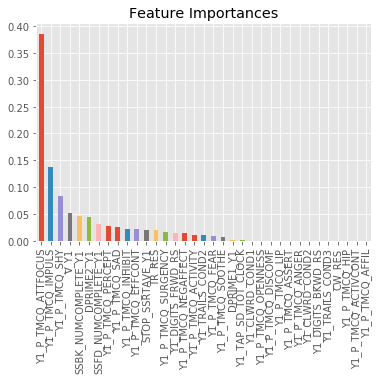

In [31]:
feat_imp = pd.Series(pipeline.steps[1][1].feature_importances_,index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [32]:
pipeline.get_params()

{'impute_transform': <impute_transform.ImputeTransform at 0x7fb961690d68>,
 'impute_transform__strategy': MatrixFactorization(fill_method='zero', l2_penalty=1e-05, learning_rate=0.001, loss='mse', max_value=None, min_improvement=0.001, min_value=None, n_imputations=1, optimization_algorithm='nadam', patience=5, rank=10, validation_frac=0.1, verbose=True),
 'memory': None,
 'steps': [('impute_transform',
   <impute_transform.ImputeTransform at 0x7fb961690d68>),
  ('xgboost',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bytree=1, gamma=0.2, learning_rate=0.01, max_delta_step=0,
          max_depth=5, min_child_weight=5, missing=None, n_estimators=190,
          n_jobs=-1, nthread=None, objective='binary:logistic',
          random_state=56, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
          seed=None, silent=True, subsample=1))],
 'xgboost': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1

In [33]:
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [2]:
xgb_model = pickle.load(open("xgboost_model.pkl", "rb"))

In [4]:
xgb_model.get_params()

{'impute_transform': <impute_transform.ImputeTransform at 0x7fa8ce4b9da0>,
 'impute_transform__strategy': MatrixFactorization(fill_method='zero', l2_penalty=1e-05, learning_rate=0.001, loss='mse', max_value=None, min_improvement=0.001, min_value=None, n_imputations=1, optimization_algorithm='nadam', patience=5, rank=10, validation_frac=0.1, verbose=True),
 'memory': None,
 'steps': [('impute_transform',
   <impute_transform.ImputeTransform at 0x7fa8ce4b9da0>),
  ('xgboost',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bytree=1, gamma=0.2, learning_rate=0.01, max_delta_step=0,
          max_depth=5, min_child_weight=5, missing=nan, n_estimators=190,
          n_jobs=-1, nthread=None, objective='binary:logistic',
          random_state=56, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
          seed=None, silent=True, subsample=1))],
 'xgboost': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1,

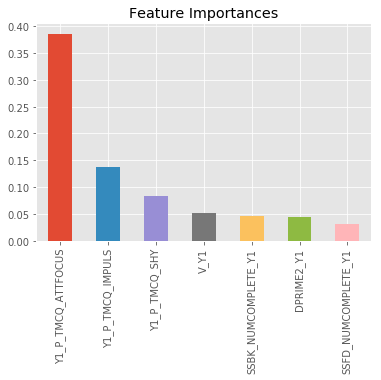

In [11]:
feat_imp = pd.Series(xgb_model.steps[1][1].feature_importances_,index=X.columns).sort_values(ascending=False)
_ = feat_imp[0:7].plot(kind='bar', title='Feature Importances')    